In [1]:
%reload_ext autoreload
%autoreload 1
%autosave 1

Autosaving every 1 seconds


In [2]:
import os
import sys
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import wandb
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from sklearn.metrics import classification_report

sys.path.append(os.path.pardir)

from src.dataset import ProlivDataset
from src.convolution_autoencoder_model import ConvAutoencoder
from src.utils import (
    inference_and_visualize,
    calculate_individual_losses,
    find_best_threshold,
    calculate_labels,
    calculate_tpr_tnr
)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Загрузка датасетов

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((30, 50)),
    transforms.ToTensor()
])

train_dataset = ProlivDataset(os.path.join(os.pardir, "dataset", "train"), 0, transform=transform)
proliv_dataset = ProlivDataset(os.path.join(os.pardir, "dataset", "proliv"), 1, transform=transform)

test_dataset_path = os.path.join(os.pardir, "dataset", "test")
test_labels = os.path.join(test_dataset_path, "test_annotation.txt")

test_dataset = ProlivDataset(os.path.join(os.pardir, "dataset", "test", "imgs"), test_labels, transform=transform)

## Инициализация параметров

In [5]:
batch_size = 128
latent_dims = 128
epochs = 200
lr = 1e-3
shuffle = True

In [6]:
# Create DataLoader
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

autoencoder = ConvAutoencoder(latent_dims=latent_dims).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

In [26]:
wandb.init(project='itmo-generative-models', entity='ildar-azamatov')

wandb: Currently logged in as: ildar-azamatov. Use `wandb login --relogin` to force relogin


In [7]:
# Configure wandb to log hyperparameters and system stats
wandb.config = {
  "epochs": epochs,
  "batch_size": batch_size,
  "latent_dims": latent_dims,
  "lr": lr,
}

## Обучение

In [8]:
# Adding wandb.watch to log gradients, parameters, and model topology
# wandb.watch(autoencoder, log='all')

for epoch in range(wandb.config["epochs"]):
    running_loss = 0.0
    for images, _ in dataloader:
        images = images.to(device)

        # Forward pass
        outputs = autoencoder(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    epoch_loss = running_loss / len(dataloader)

    # Logging the metrics to wandb
    # wandb.log({"epoch": epoch + 1, "loss": epoch_loss})

    print(f'Epoch [{epoch+1}/{wandb.config["epochs"]}], Loss: {epoch_loss:.10f}')

# wandb.finish()
print('Training completed')

Epoch [1/200], Loss: 0.0022963622
Epoch [2/200], Loss: 0.0012941760
Epoch [3/200], Loss: 0.0006610564
Epoch [4/200], Loss: 0.0004274041
Epoch [5/200], Loss: 0.0003083515
Epoch [6/200], Loss: 0.0002494900
Epoch [7/200], Loss: 0.0002197635
Epoch [8/200], Loss: 0.0001855081
Epoch [9/200], Loss: 0.0001643536
Epoch [10/200], Loss: 0.0001533766
Epoch [11/200], Loss: 0.0001462201
Epoch [12/200], Loss: 0.0001341280
Epoch [13/200], Loss: 0.0001299767
Epoch [14/200], Loss: 0.0001229038
Epoch [15/200], Loss: 0.0001221071
Epoch [16/200], Loss: 0.0001111122
Epoch [17/200], Loss: 0.0001102536
Epoch [18/200], Loss: 0.0001110559
Epoch [19/200], Loss: 0.0001009298
Epoch [20/200], Loss: 0.0001002559
Epoch [21/200], Loss: 0.0000950488
Epoch [22/200], Loss: 0.0000939717
Epoch [23/200], Loss: 0.0000917144
Epoch [24/200], Loss: 0.0000921295
Epoch [25/200], Loss: 0.0000879425
Epoch [26/200], Loss: 0.0000866475
Epoch [27/200], Loss: 0.0000844795
Epoch [28/200], Loss: 0.0000808920
Epoch [29/200], Loss: 0.00008

In [24]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,200
loss,0.00029


## Инференс

In [9]:
autoencoder.eval()

ConvAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc): Linear(in_features=96000, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=128, out_features=96000, bias=True)
    (deconv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deconv2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deconv3): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

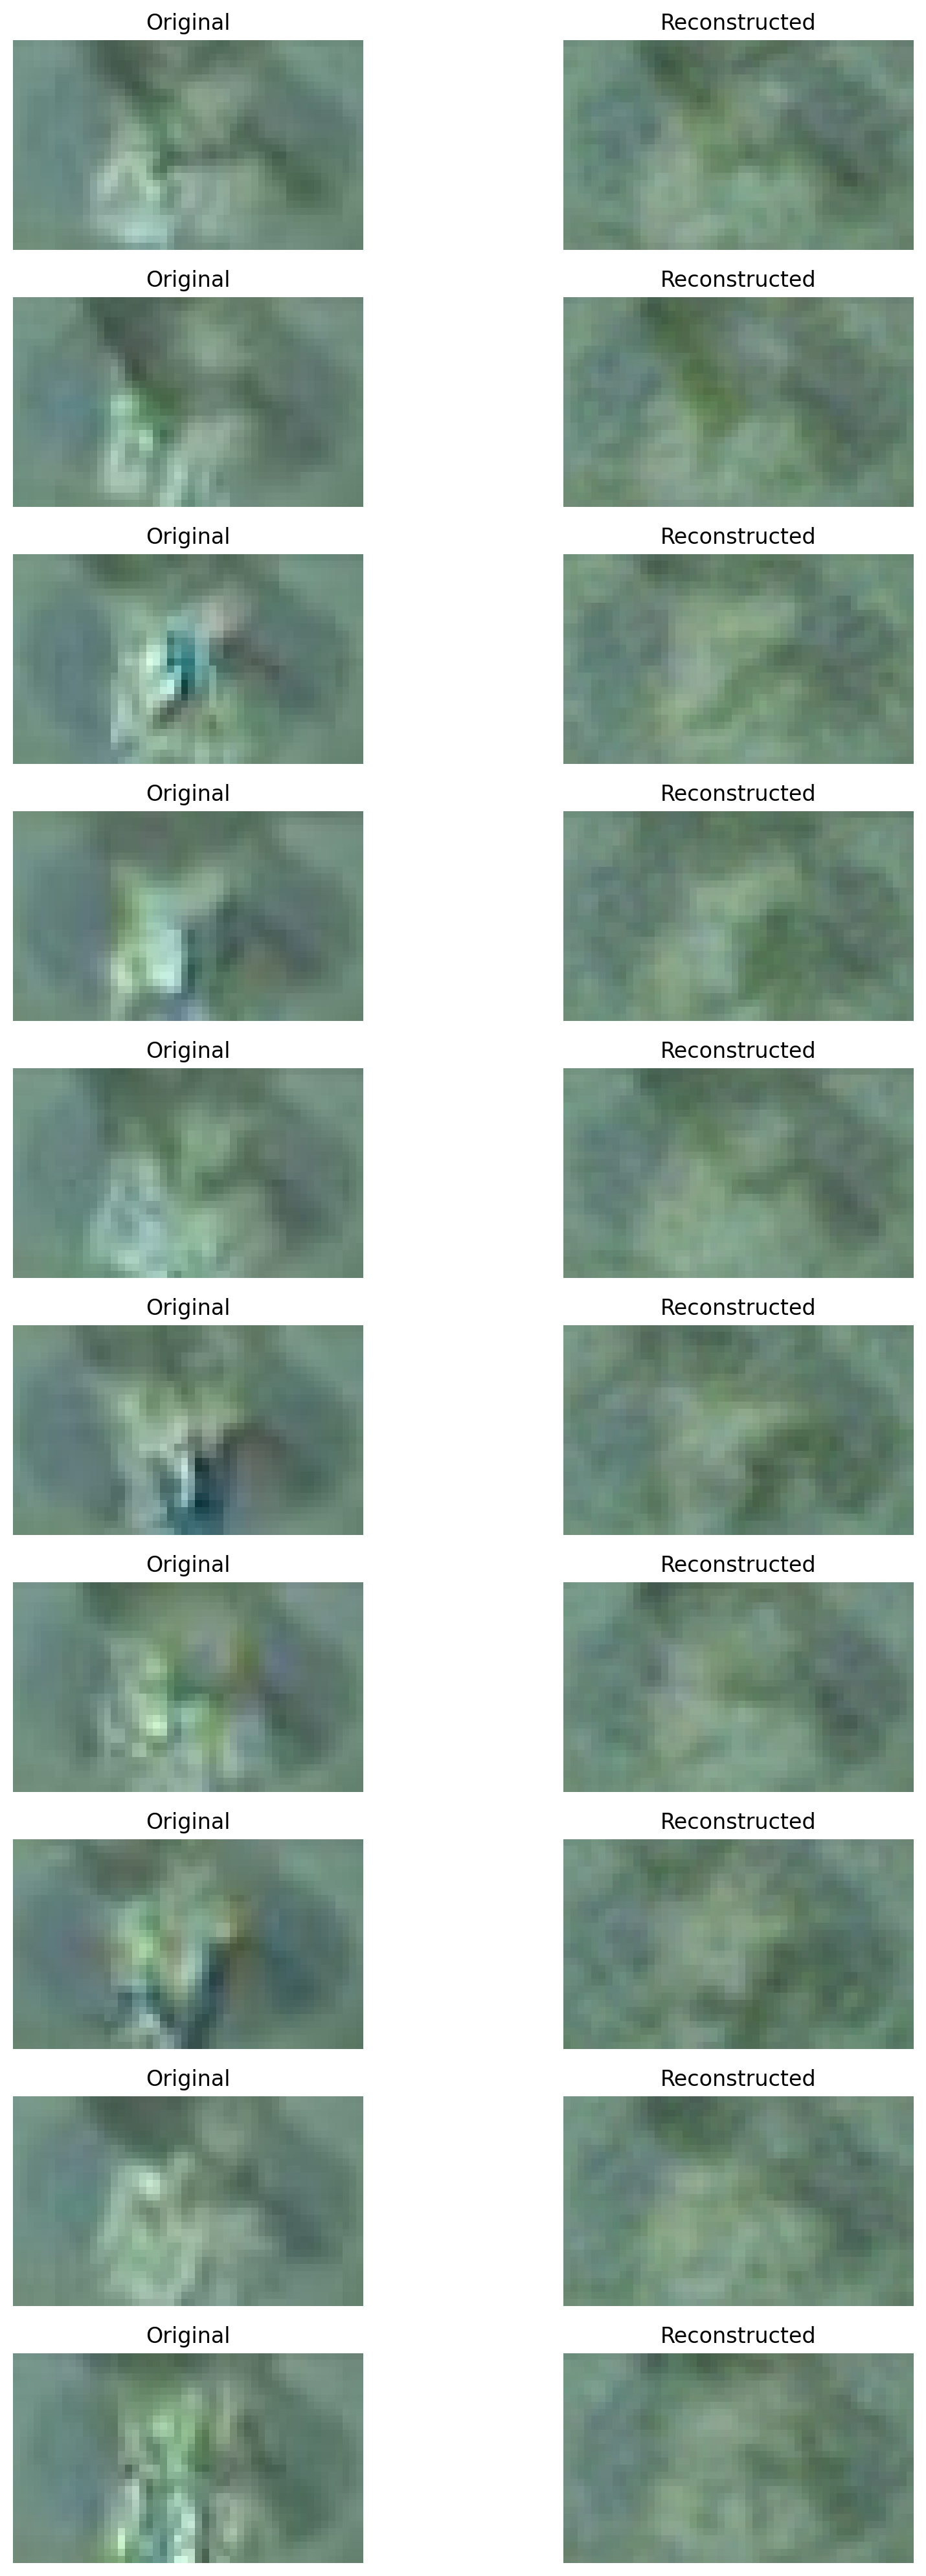

In [10]:
inference_and_visualize(proliv_dataset, autoencoder, device)

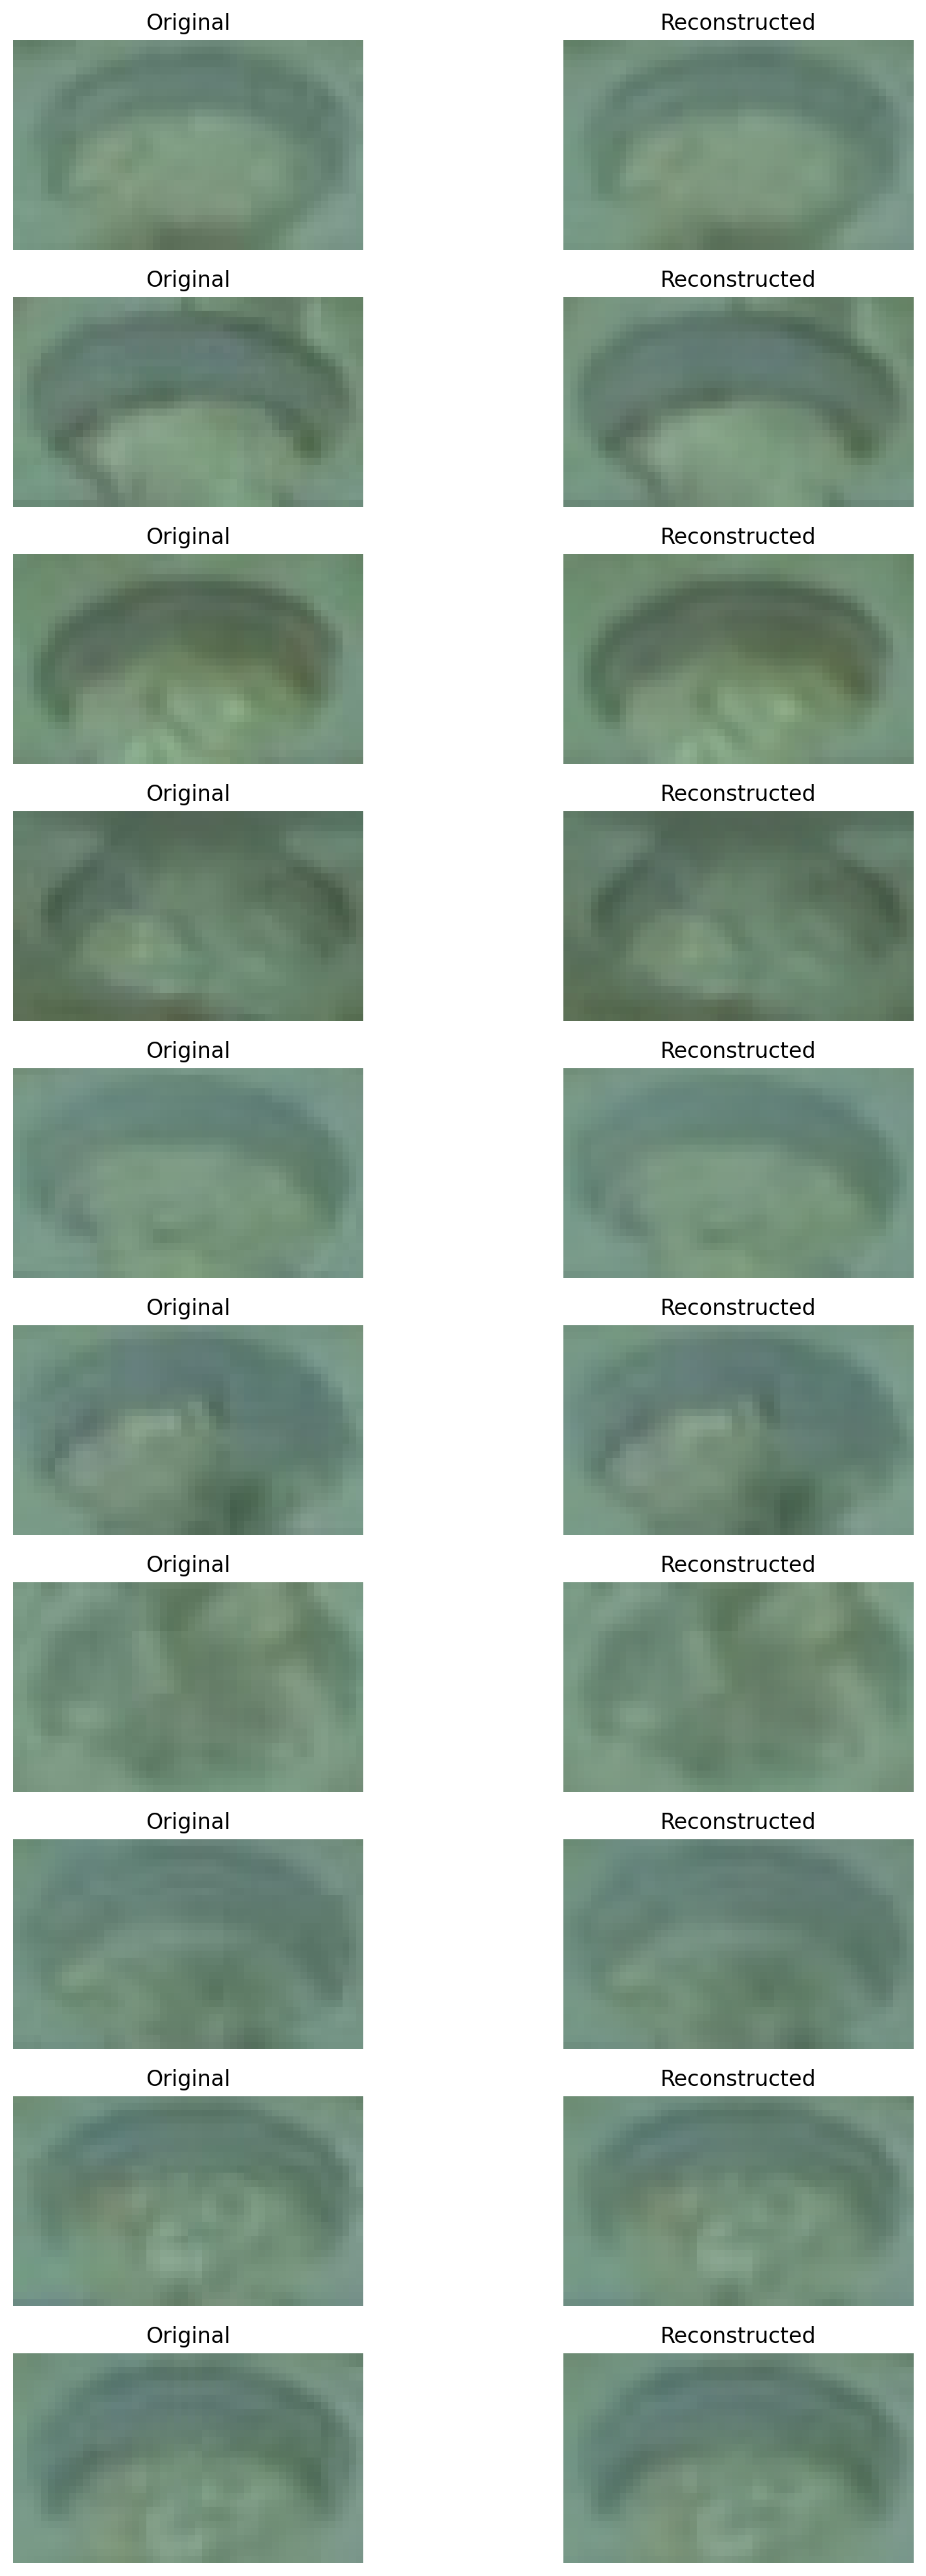

In [11]:
inference_and_visualize(train_dataset, autoencoder, device)

### Ищём threshold для классификации

In [12]:
train_losses = calculate_individual_losses(train_dataset, autoencoder, device)
proliv_losses = calculate_individual_losses(proliv_dataset, autoencoder, device)
test_losses = calculate_individual_losses(test_dataset, autoencoder, device)

In [16]:
test_losses = calculate_individual_losses(test_dataset, autoencoder, device)

In [13]:
best_threshold = find_best_threshold(proliv_losses, train_losses)

In [14]:
best_threshold

0.0006622434593737125

In [17]:
pred = calculate_labels(test_losses, best_threshold)

### Метрики

In [18]:
calculate_tpr_tnr(test_dataset.labels["label"].values, pred)

{'TPR': 0.8372093023255814, 'TNR': 0.7784447476125511}

In [19]:
print(classification_report(test_dataset.labels["label"].values, pred))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      3665
           1       0.12      0.84      0.21       129

    accuracy                           0.78      3794
   macro avg       0.56      0.81      0.54      3794
weighted avg       0.96      0.78      0.85      3794

